<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Yalda Shabanzadeh
### Student Number : 98101822
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import seaborn as sn
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=838a9cdf0ee7b910bd7e042e14e35fe9616f8ca44bb3f3db3c4fc9666ee6e398
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [ ]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [ ]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [ ]:
batch_size = 16
num_workers = 2

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [ ]:
class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=10),
            nn.Softmax()
        )

    def forward(self, x):
        out1 = self.block1(x)
        out2 = self.block2(out1)
        out2 = torch.stack((out1, out2), 1).sum(1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        out4 = torch.stack((out3, out4), 1).sum(1)
        out = self.avg_pool(out4)
        out = self.classifier(out)
        return out

In [ ]:
net = ResidualClassifier()

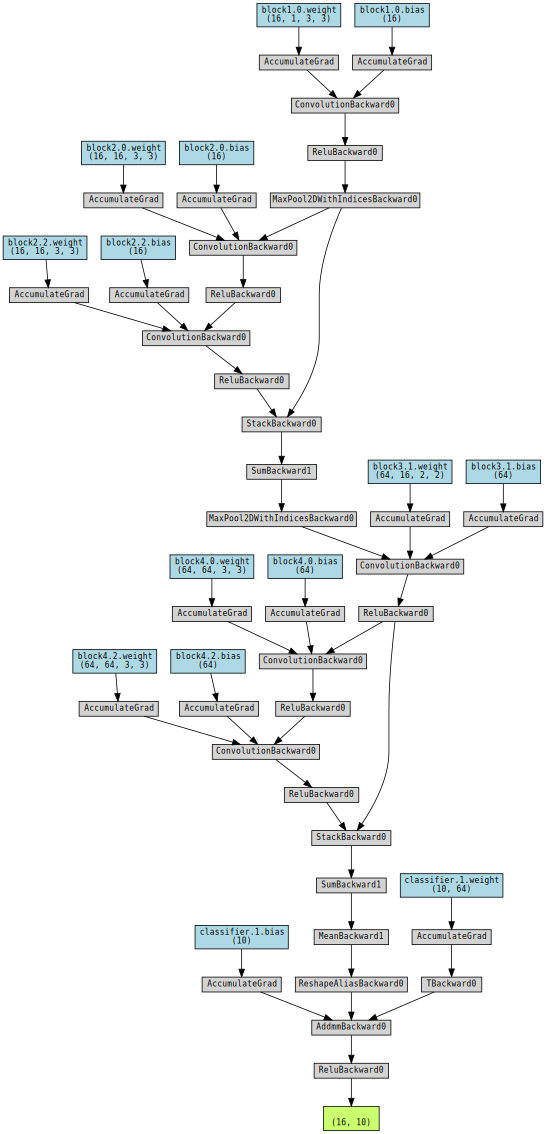

In [ ]:
from torchviz import make_dot


batch = next(iter(train_loader))
yhat = net(batch[0])
make_dot(yhat, params=dict(list(net.named_parameters())))

# Train Model (30 Points)

In [ ]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################

learning_rate = 1e-4

model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer
):
    train_loss = 0
    correct = 0
    N = 0
    total_pred = torch.tensor([]).to(device)
    total_true = torch.tensor([]).to(device)
    model.to(device)
    model.train()
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (inputs, labels) in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()

            total_pred = torch.cat((total_pred, predicted))
            total_true = torch.cat((total_true, labels))
            
            N += labels.shape[0]
            acc = correct / N
            pbar.set_description(f'Train   {epoch} | Loss:{train_loss/N:.2e} | Acc: {acc:.2f}')

    return train_loss, acc, f1_score(total_true.cpu(), total_pred.cpu(), average='macro')

In [ ]:
def eval_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module = None,
):
    val_loss = 0
    correct = 0
    N = 0
    total_pred = torch.tensor([]).to(device)
    total_true = torch.tensor([]).to(device)
    model.to(device)
    with torch.no_grad():
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (inputs, labels) in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss = loss.item()

                val_loss += epoch_loss
                predicted = outputs.argmax(dim=1)
                correct += (predicted == labels).sum().item()

                total_pred = torch.cat((total_pred, predicted))
                total_true = torch.cat((total_true, labels))

                N += labels.shape[0]
                acc = correct / N
                pbar.set_description(f'Val     {epoch} | Loss:{val_loss/N:.2e} | Acc: {acc:.2f}')
    return val_loss, acc, f1_score(total_true.cpu(), total_pred.cpu(), average='macro') 

In [ ]:
num_epochs = 20
least_loss = float('inf')
best_epoch_dict = None
train_losses, val_losses = list(), list()
train_accs, val_accs = list(), list()
train_f1s, val_f1s = list(), list()


for epoch in range(num_epochs):  # loop over the dataset multiple times

    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    if train_loss < least_loss:
        least_loss = train_loss
        best_epoch_dict = model.state_dict().copy()
    
    print(f'\n[Epoch {epoch}]\t'
        f'Train Loss: {train_loss:.4f}\t'
        f'Validation Loss: {val_loss:.4f}\t'
    )

print('Finished Training')

Train   0 | Loss:6.75e-02 | Acc: 0.65: 100%|██████████| 3125/3125 [00:44<00:00, 69.55it/s]
Val     0 | Loss:4.40e-02 | Acc: 0.75: 100%|██████████| 3125/3125 [00:32<00:00, 97.49it/s]



[Epoch 0]	Train Loss: 1.0794	Validation Loss: 0.7045	


Train   1 | Loss:4.15e-02 | Acc: 0.76: 100%|██████████| 3125/3125 [00:45<00:00, 68.37it/s]
Val     1 | Loss:3.97e-02 | Acc: 0.76: 100%|██████████| 3125/3125 [00:32<00:00, 97.49it/s]



[Epoch 1]	Train Loss: 0.6638	Validation Loss: 0.6357	


Train   2 | Loss:3.72e-02 | Acc: 0.78: 100%|██████████| 3125/3125 [00:45<00:00, 69.22it/s]
Val     2 | Loss:3.52e-02 | Acc: 0.78: 100%|██████████| 3125/3125 [00:32<00:00, 96.89it/s]



[Epoch 2]	Train Loss: 0.5956	Validation Loss: 0.5629	


Train   3 | Loss:3.50e-02 | Acc: 0.78: 100%|██████████| 3125/3125 [00:45<00:00, 68.62it/s]
Val     3 | Loss:3.48e-02 | Acc: 0.78: 100%|██████████| 3125/3125 [00:32<00:00, 94.94it/s]



[Epoch 3]	Train Loss: 0.5595	Validation Loss: 0.5575	


Train   4 | Loss:3.35e-02 | Acc: 0.79: 100%|██████████| 3125/3125 [00:45<00:00, 69.12it/s]
Val     4 | Loss:3.20e-02 | Acc: 0.79: 100%|██████████| 3125/3125 [00:32<00:00, 96.66it/s]



[Epoch 4]	Train Loss: 0.5352	Validation Loss: 0.5117	


Train   5 | Loss:3.24e-02 | Acc: 0.79: 100%|██████████| 3125/3125 [00:45<00:00, 69.35it/s]
Val     5 | Loss:3.17e-02 | Acc: 0.79: 100%|██████████| 3125/3125 [00:31<00:00, 97.87it/s]



[Epoch 5]	Train Loss: 0.5182	Validation Loss: 0.5064	


Train   6 | Loss:3.17e-02 | Acc: 0.79: 100%|██████████| 3125/3125 [00:46<00:00, 67.76it/s]
Val     6 | Loss:3.18e-02 | Acc: 0.79: 100%|██████████| 3125/3125 [00:32<00:00, 96.91it/s]



[Epoch 6]	Train Loss: 0.5065	Validation Loss: 0.5089	


Train   7 | Loss:3.12e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 69.39it/s]
Val     7 | Loss:3.01e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:32<00:00, 97.30it/s] 



[Epoch 7]	Train Loss: 0.4985	Validation Loss: 0.4822	


Train   8 | Loss:3.06e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 69.01it/s]
Val     8 | Loss:2.99e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:33<00:00, 94.42it/s]



[Epoch 8]	Train Loss: 0.4896	Validation Loss: 0.4786	


Train   9 | Loss:3.03e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 69.17it/s]
Val     9 | Loss:2.95e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:31<00:00, 97.85it/s] 



[Epoch 9]	Train Loss: 0.4848	Validation Loss: 0.4712	


Train   10 | Loss:3.00e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:44<00:00, 69.64it/s]
Val     10 | Loss:2.97e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:32<00:00, 97.54it/s]



[Epoch 10]	Train Loss: 0.4796	Validation Loss: 0.4747	


Train   11 | Loss:2.97e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 68.20it/s]
Val     11 | Loss:2.96e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:32<00:00, 97.24it/s] 



[Epoch 11]	Train Loss: 0.4749	Validation Loss: 0.4738	


Train   12 | Loss:2.94e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 69.38it/s]
Val     12 | Loss:2.91e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:32<00:00, 97.13it/s]



[Epoch 12]	Train Loss: 0.4711	Validation Loss: 0.4649	


Train   13 | Loss:2.93e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:44<00:00, 69.63it/s]
Val     13 | Loss:2.90e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:32<00:00, 94.95it/s]



[Epoch 13]	Train Loss: 0.4686	Validation Loss: 0.4644	


Train   14 | Loss:2.91e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 68.30it/s]
Val     14 | Loss:2.87e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:32<00:00, 96.37it/s]



[Epoch 14]	Train Loss: 0.4654	Validation Loss: 0.4594	


Train   15 | Loss:2.90e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:45<00:00, 67.96it/s]
Val     15 | Loss:2.86e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:32<00:00, 96.02it/s]



[Epoch 15]	Train Loss: 0.4633	Validation Loss: 0.4569	


Train   16 | Loss:2.88e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:46<00:00, 67.06it/s]
Val     16 | Loss:2.84e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:32<00:00, 96.92it/s]



[Epoch 16]	Train Loss: 0.4604	Validation Loss: 0.4545	


Train   17 | Loss:2.86e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:45<00:00, 68.53it/s]
Val     17 | Loss:2.82e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:32<00:00, 97.36it/s] 



[Epoch 17]	Train Loss: 0.4583	Validation Loss: 0.4509	


Train   18 | Loss:2.85e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:45<00:00, 69.12it/s]
Val     18 | Loss:2.89e-02 | Acc: 0.80: 100%|██████████| 3125/3125 [00:33<00:00, 94.50it/s]



[Epoch 18]	Train Loss: 0.4565	Validation Loss: 0.4623	


Train   19 | Loss:2.84e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:45<00:00, 69.32it/s]
Val     19 | Loss:2.85e-02 | Acc: 0.81: 100%|██████████| 3125/3125 [00:32<00:00, 97.08it/s]



[Epoch 19]	Train Loss: 0.4549	Validation Loss: 0.4562	
Finished Training


In [ ]:
def plot_metrics(title, train_metrics, val_metrics):
    plt.figure(figsize=(15, 10))
    plt.plot(train_metrics, 'b', label=f'Train {title}')
    plt.plot(val_metrics, 'r', label=f'Validataion {title}')
    plt.xlabel('Epochs number')
    plt.ylabel(title)
    plt.legend()

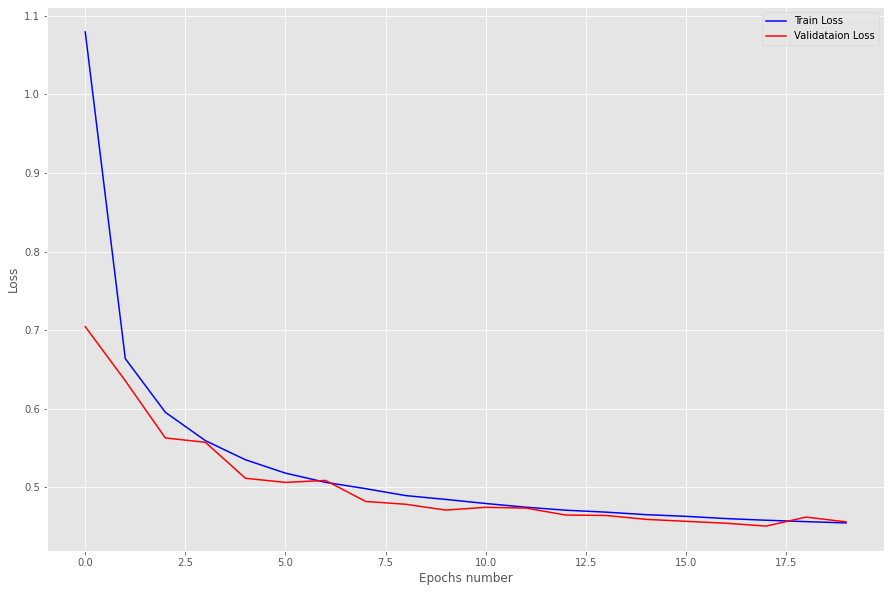

In [ ]:
plot_metrics('Loss', train_losses, val_losses)

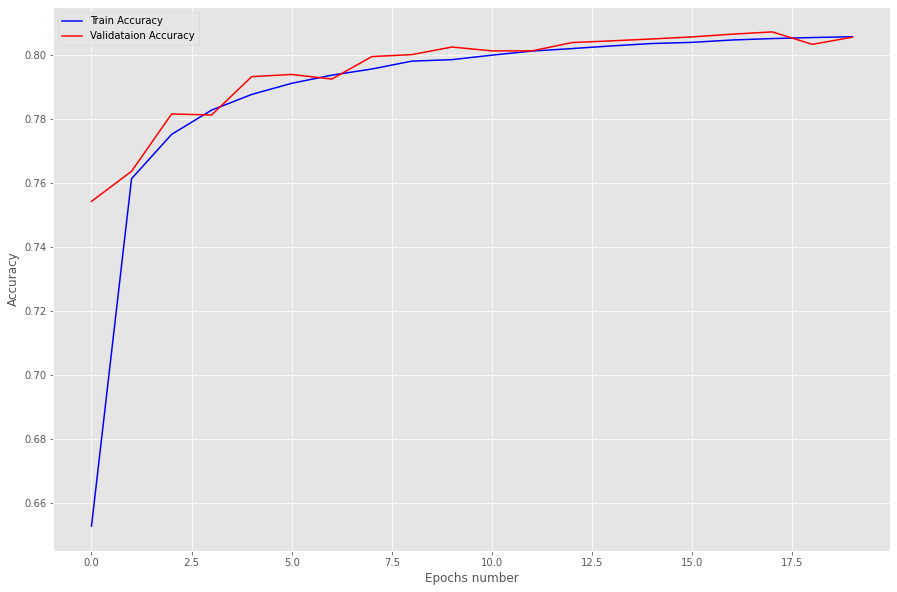

In [ ]:
plot_metrics('Accuracy',train_accs, val_accs)

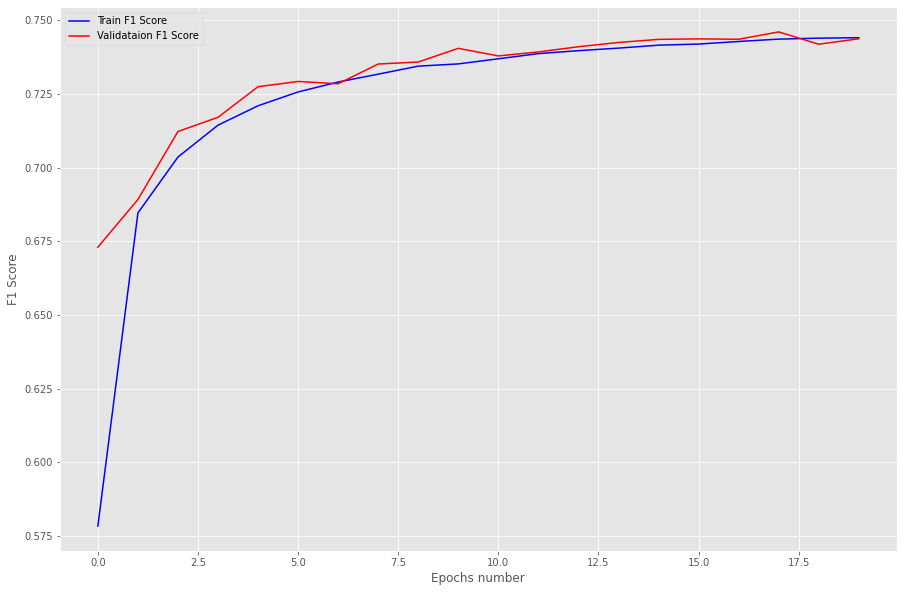

In [ ]:
plot_metrics('F1 Score', train_f1s, val_f1s)

# Test Model (20 Points)

In [ ]:
test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

total = 0
correct = 0

with torch.no_grad():
    for _, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

10000
Accuracy of the network on the test images: 80.60 %


In [ ]:
classes = list(range(10))

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_true = list()
y_pred = list()

# again no gradients needed
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_true.append([int(label)])
            y_pred.append([int(prediction)])


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 99.4 %
Accuracy for class: 1 is 99.5 %
Accuracy for class: 2 is 99.3 %
Accuracy for class: 3 is 97.7 %
Accuracy for class: 4 is 99.5 %
Accuracy for class: 5 is 0.0 %
Accuracy for class: 6 is 0.0 %
Accuracy for class: 7 is 99.1 %
Accuracy for class: 8 is 97.7 %
Accuracy for class: 9 is 98.8 %


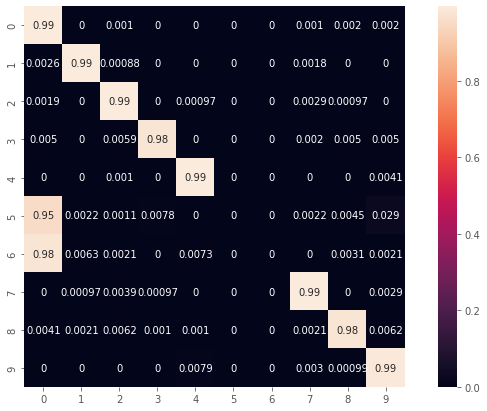

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True, square=True)
plt.savefig('conf_matrix.png')